# YouTube Views Prediction - Part II
## Data Analysis and Machine Learning Models

### Table of Content

2. Describe data and feature engineering </br>
	&emsp;2.1 Describe data </br>
	&emsp;2.2 Data clean and preparation </br>
	&emsp;2.3 Data analysis and visualization </br>
	&emsp;2.4 Feature selection </br>
	
3. Build Machine Learning models with hyperparameter tune	 </br>
	&emsp;3.1 Numeric Models - include 'likes' and 'comments' in features </br>
		&emsp;&emsp;3.1.1 Random Forest Model (include 'likes' and 'comments' ) </br>
		&emsp;&emsp;3.1.2 Decision Tree Model (include 'likes' and 'comments' ) </br>
	&emsp;3.2 Numeric Models - exclude likes and comments in the features </br> 
		&emsp;&emsp;3.2.1 Random Forest Model </br>
		&emsp;&emsp;3.2.2 Decision Tree Model </br>
	&emsp;3.3 Text Models </br>
		&emsp;&emsp;3.3.1 Use Video Description to predict views </br>
			&emsp;&emsp;&emsp;3.3.1.1 RidgeCV Model </br>
			&emsp;&emsp;&emsp;3.3.1.2 MLP Model </br>
		&emsp;&emsp;3.3.2 Use Video Title to predict views </br>
			&emsp;&emsp;&emsp;3.3.2.1 RidgeCV Model </br>
			&emsp;&emsp;&emsp;3.3.2.2 MLP Model </br>
		&emsp;&emsp;3.3.3 Use Video Tags to predict views  </br>
			&emsp;&emsp;&emsp;3.3.3.1 RidgeCV Model </br>
			&emsp;&emsp;&emsp;3.3.3.2 MLP Model </br>
	&emsp;3.4 Combine three text models: Tags, Titles, and Descriptions </br>
		&emsp;&emsp;3.4.1 Category data model </br>
	&emsp;3.5 Full model include numeric and categories data </br>
		&emsp;&emsp;3.5.1 Full Model - RidgeCV </br>
		&emsp;&emsp;3.5.2 Full Model - MLP Model </br>


## 2. Describe data and feature engineering

#### 2.1 Describe data

In [2]:
## Load video data from file
import dill

with open('Data/fitness-video-data', 'rb') as f:
    fitness_df = dill.load(f)

In [246]:
fitness_df.describe()

,video_len_in_sec
count,24576.000000
mean,363.004395
std,1295.206154
min,0.000000
25%,14.000000
50%,30.000000
75%,247.000000
max,42899.000000


In [247]:
fitness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24576 entries, 0 to 24575
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country_code                  24576 non-null  object 
 1   video_id                      24576 non-null  object 
 2   published_at                  24576 non-null  object 
 3   published_date                24576 non-null  object 
 4   data_fetch_date               24576 non-null  object 
 5   title                         24576 non-null  object 
 6   description                   24576 non-null  object 
 7   thumbnail_link                24576 non-null  object 
 8   video_len_in_sec              24576 non-null  float64
 9   views                         24576 non-null  object 
 10  likes                         24576 non-null  object 
 11  comments                      24576 non-null  object 
 12  tags                          24576 non-null  object 
 13  c

#### 2.2  Data Clean and Preparation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer 
from collections import Counter
from pprint import pprint
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import pickle
import dill
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jzhou01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# =====================================================================
# Function to convert a raw tags to a string of words
# The input is a single string (a raw video tags), and
# the output is a single string (a preprocessed video tags)
# =====================================================================
def tags_to_words(raw_tags):
    words = raw_tags.lower().split('|') 
    # In Python, searching a set is much faster than searching a list,
    # so convert the stop words to a set to improve execution time this conversion should be done once
    stops = set(stopwords.words("english"))

    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]

    # Join the words back into one string separated by space, and return the result.
    return (",".join(meaningful_words))


# =============================================================
# Function to convert a raw tags to a string of words
# The input is a single string (a raw video tags), and
# the output is a single string (a preprocessed video tags)
# =============================================================
def sentence_to_words(raw_sentence):
    words = raw_sentence.lower().split(' ')
    stops = set(stopwords.words("english"))    
    meaningful_words = [w for w in words if not w in stops]
    return (",".join(meaningful_words))

In [5]:
# We use fitness_data moving forward for data massaging and model training
fitness_data = fitness_df

# Add lenth of tag, title, and description 
fitness_data['tag_cnt'] = fitness_data.apply(lambda x: len(x['tags'].split('|')), axis=1)
fitness_data['title_len'] = fitness_data.apply(lambda x: len(x['title'].split(' ')), axis=1)
fitness_data['desc_len'] = fitness_data.apply(lambda x: len(x['description'].split(' ')), axis=1)

# Add cleaned tags, title and decription
fitness_data['cleaned_tags'] = fitness_data.apply(lambda x: tags_to_words(x['tags']), axis=1)
fitness_data['cleaned_title'] = fitness_data.apply(lambda x: sentence_to_words(x['title']), axis=1)
fitness_data['cleaned_description'] = fitness_data.apply(lambda x: sentence_to_words(x['description']), axis=1)


In [251]:
# # show sample of results
# print(f'>>> tags')
# print(f"<tags:>   {fitness_data['tags'][1]}")
# print(f"<cleaned_tags:>   {fitness_data['cleaned_tags'][1]}")
# print(f"<tag_cnt:>   {fitness_data['tag_cnt'][1]}")      

# print('\n' + f'>>> titles')
# print(f"<titles:>   {fitness_data['title'][1]}")
# print(f"<cleaned_titles':>   {fitness_data['cleaned_title'][1]}") 
# print(f"<titles_len:>   {fitness_data['title_len'][1]}")

# print('\n' + f'>>> descriptions')
# print(f"<description:>   {fitness_data['description'][50]}")
# print(f"<cleaned_description':>   {fitness_data['cleaned_description'][50]}") 
# print(f"<desc_len:>   {fitness_data['desc_len'][50]}")



In [252]:
# Check data types
fitness_data.dtypes

country_code                     object
video_id                         object
published_at                     object
published_date                   object
data_fetch_date                  object
title                            object
description                      object
thumbnail_link                   object
video_len_in_sec                float64
views                            object
likes                            object
comments                         object
tags                             object
channel_id                       object
channel_title                    object
channel_description              object
channel_published_time           object
channel_views                    object
channel_subscriber_count         object
channel_video_count              object
channel_topic_ids                object
channel_topic_categories         object
channel_topic_categories_ref     object
channel_keywords                 object
channel_published_date           object


In [253]:
 # remove non-english
# channel_published_time need to change to length 

In [6]:
ids = ['video_id', 'channel_id'] 

time = ['channel_published_time']

cats = ['title', 'description', 'tags', 'cleaned_tags', 'cleaned_title', 'cleaned_description']

vcats = ['thumbnail_link', 'published_at', 'published_date', 'data_fetch_date']
ccats = ['channel_title', 'channel_description', 
        'channel_subscriber_count', 'channel_topic_ids', 'channel_topic_categories', 
        'channel_topic_categories_ref', 'channel_keywords', 'channel_published_date']
                
nums = ['views', 'video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len',
        'channel_subscriber_count', 'channel_video_count', 'channel_views',
        'likes', 'comments']

cnums = ['country_code', 'category_id']

features = ['channel_id', 'views',
            'cleaned_tags', 'cleaned_title', 'cleaned_description', 
            'video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len',
            'channel_subscriber_count', 'channel_video_count', 'channel_views']

# Convert string to int
fitness_data['likes'] = fitness_data['likes'].astype(str).astype(float)
fitness_data['comments'] = fitness_data['comments'].astype(str).astype(float)

# fitness_data['views'] = fitness_data['views'].astype(str).astype(int)
# fitness_data['video_len_in_sec'] = fitness_data['video_len_in_sec'].astype(int)
# fitness_data['channel_views'] = fitness_data['channel_views'].astype(str).astype('int64')
# fitness_data['channel_subscriber_count'] = fitness_data['channel_subscriber_count'].astype(str).astype(int)
# fitness_data['channel_video_count'] = fitness_data['channel_video_count'].astype(str).astype(int)


# Numerical features 
NumCol = ['views', 'video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len', 
          'channel_subscriber_count', 'channel_video_count', 'channel_views']    
fitness_data[NumCol] = fitness_data[NumCol].apply(pd.to_numeric, errors='coerce', axis=1)
# fitness_data[NumCol][:3]

# Category features
CatCol = ['cleaned_tags', 'cleaned_title', 'cleaned_description']
fitness_data[CatCol][:3]      

,cleaned_tags,cleaned_title,cleaned_description
0,"tmf,teachign mens fashion,jose zuniga,mens wea...","7,fitness,hacks,quickly,increase,muscle","check,new,kove,commuter,2,speaker,here:,http:/..."
1,"the body coach,joe wicks,kids workout,lean in ...","super,fun,kid&#39;s,workout!,8-minute,hiit,fit...","let's,kid,fit,go!,first,8-minute,hiit,session,..."
2,"kids workout at home,kids workout,kids fitness...","10x,fitness,games,-,kids,workout,exercise,game...","workout,fitness,games,kids,home,suitable,whole..."


In [255]:
# Numerical data 
fitness_data[nums].describe() 

,views,video_len_in_sec,tag_cnt,title_len,desc_len,channel_subscriber_count,channel_video_count,channel_views,likes,comments
count,2.457600e+04,24576.000000,24576.000000,24576.000000,24576.000000,2.457600e+04,24576.000000,2.457600e+04,2.457600e+04,24576.000000
mean,3.835375e+05,363.004395,7.660645,9.600627,10.762573,3.328180e+05,1194.326701,1.144604e+08,1.202569e+04,134.007731
std,2.536518e+06,1295.206154,10.295195,3.826912,9.545538,1.447193e+06,9295.242487,6.357698e+08,7.248181e+04,713.872489
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,9.440000e+02,14.000000,1.000000,7.000000,1.000000,7.170000e+02,109.000000,1.731850e+05,1.700000e+01,0.000000
50%,3.518000e+03,30.000000,1.000000,9.000000,10.000000,6.800000e+03,265.000000,1.539288e+06,7.500000e+01,3.000000
75%,4.109175e+04,247.000000,13.000000,12.000000,20.000000,1.260000e+05,621.250000,3.566015e+07,1.072250e+03,38.250000
max,8.827456e+07,42899.000000,75.000000,60.000000,40.000000,1.110000e+08,410883.000000,2.889718e+10,3.112374e+06,43040.000000


In [256]:
#look for unique values from each categorical data
data_cat_unique = fitness_data[CatCol].nunique().reset_index()
data_cat_unique.columns = ['name', 'unique']
data_cat_unique = data_cat_unique.sort_values('unique', ascending=False)
data_cat_unique

,name,unique
1,cleaned_title,22954
2,cleaned_description,12193
0,cleaned_tags,9046


##### 2.3 Data analysis and visualization

##### Graphical Analysis

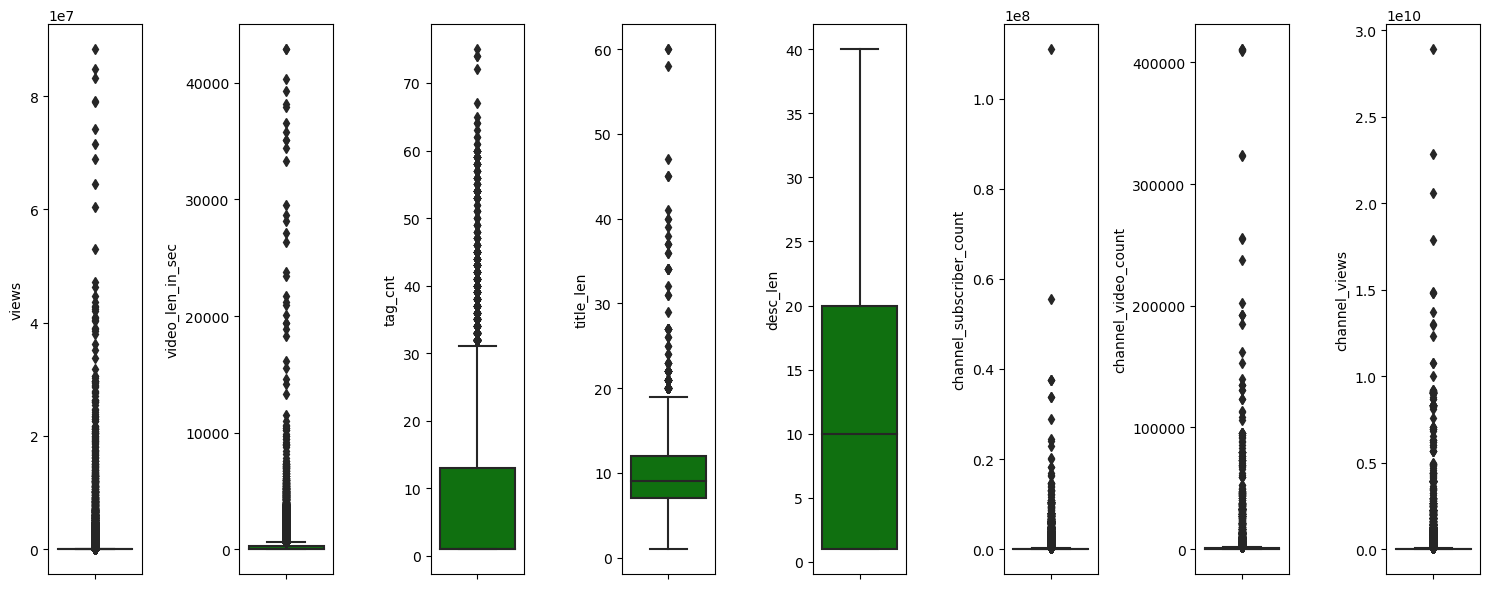

In [635]:
# look at the distribution of numerical feature data with boxplot

plt.figure(figsize = (15, 6))
for i in range(0, len(NumCol)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y = fitness_data[NumCol[i]], color='green', orient='v')
    plt.tight_layout();
# plt.savefig('Fig/boxplot.png')

##### Multivariate Analysis

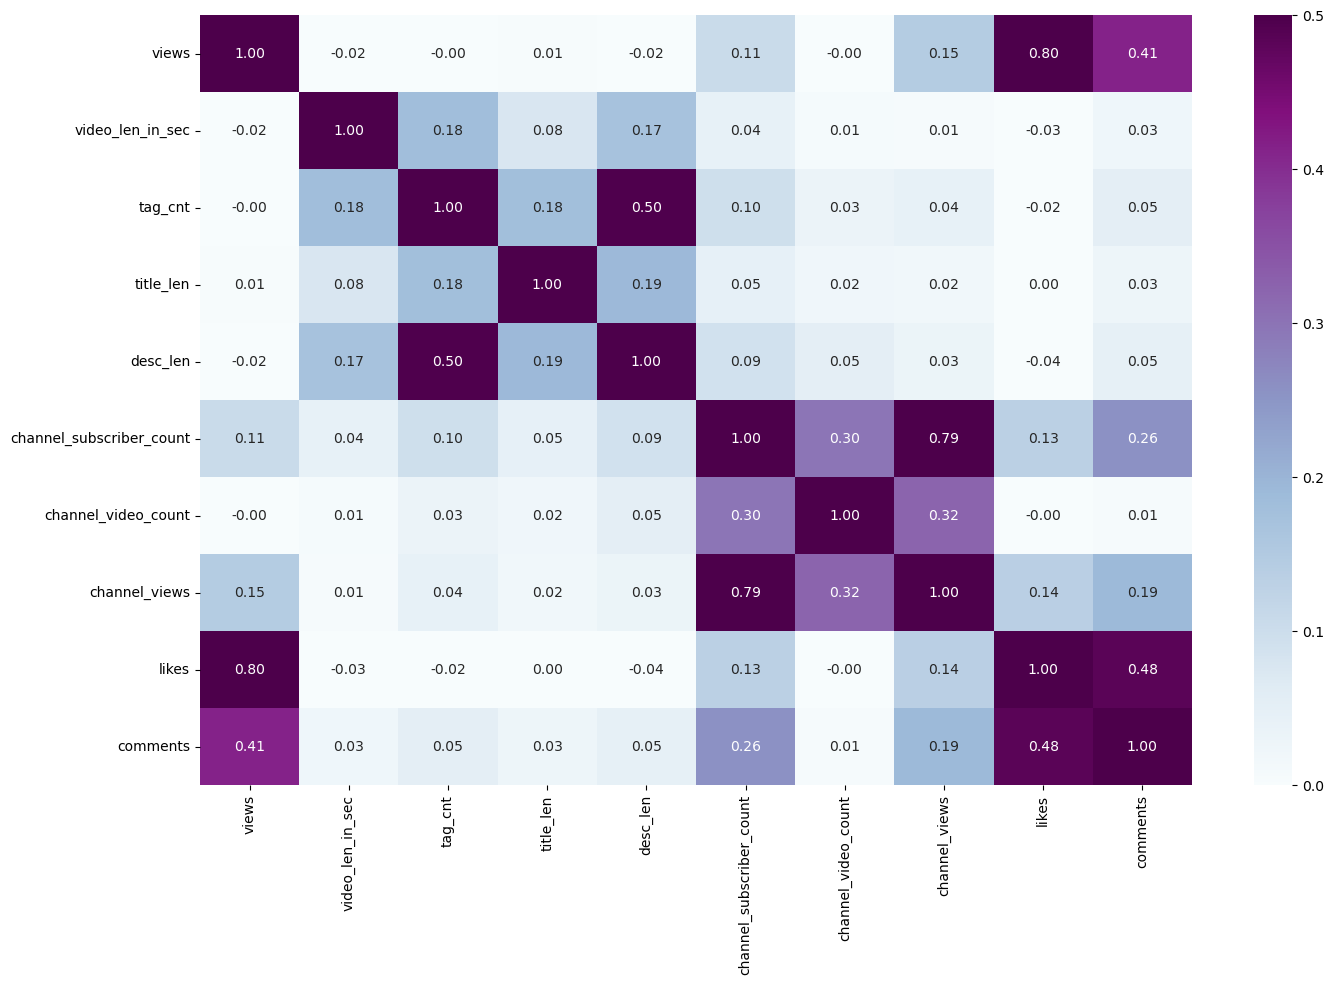

In [538]:
# create a correlation matrix from numeric data

corr_= fitness_data[nums].corr(numeric_only = True)
plt.figure(figsize = (16, 10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu", vmin=0, vmax=0.5);
# plt.savefig('Fig/heatmap.png');

<Figure size 1000x800 with 0 Axes>

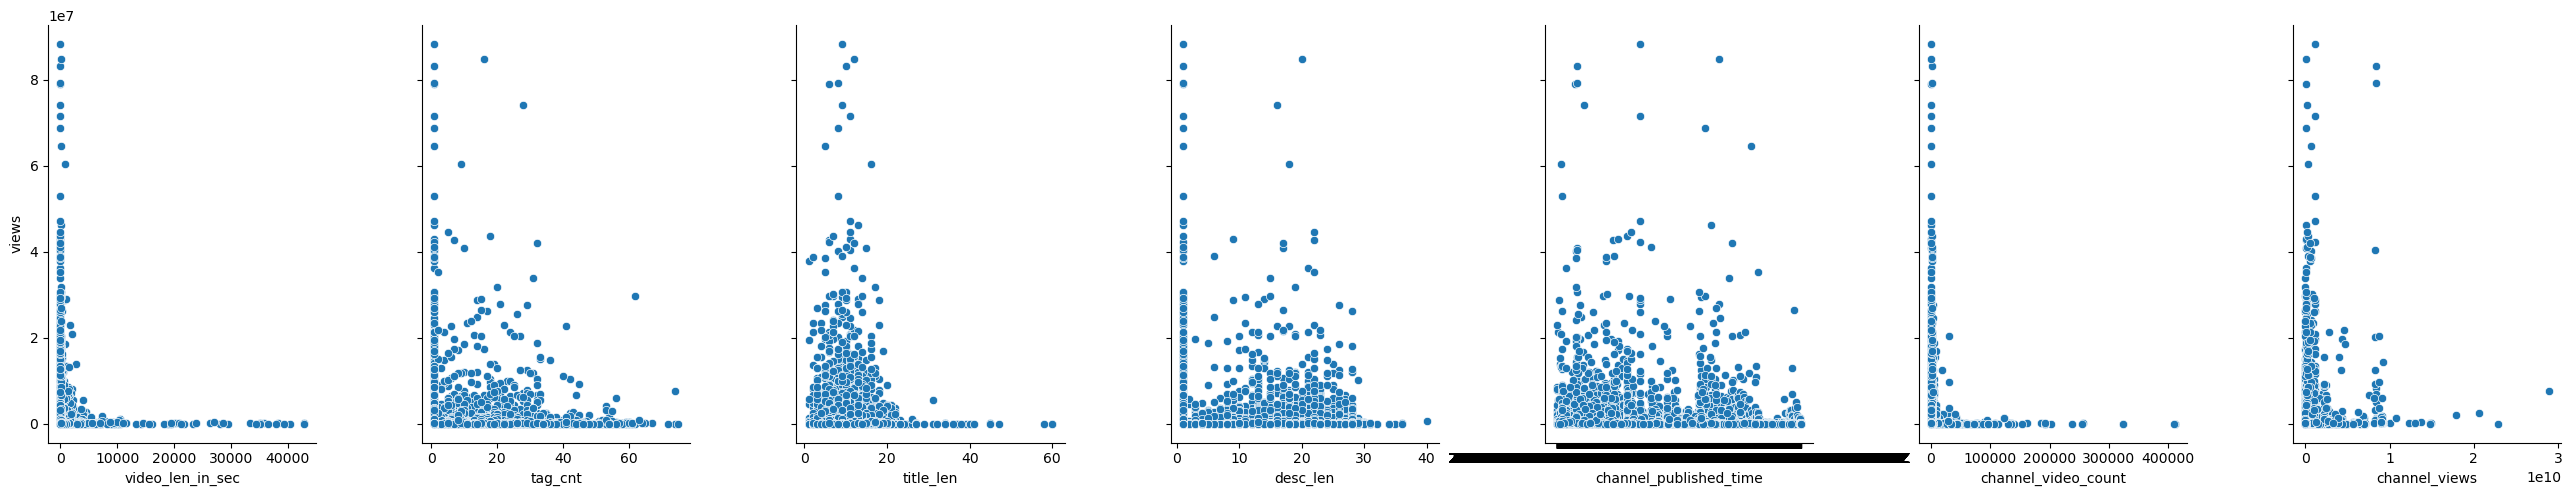

In [360]:
#create a pairplot graph from each numeric data
fig = plt.figure(figsize=(10,8))
sns.pairplot(data=fitness_data, 
             x_vars=['video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len',
                     'channel_published_time', 'channel_video_count', 'channel_views'],                                  
             y_vars=['views'], height=5, aspect=0.75);

fig.tight_layout();
plt.savefig('Fig/pairplot7.png')

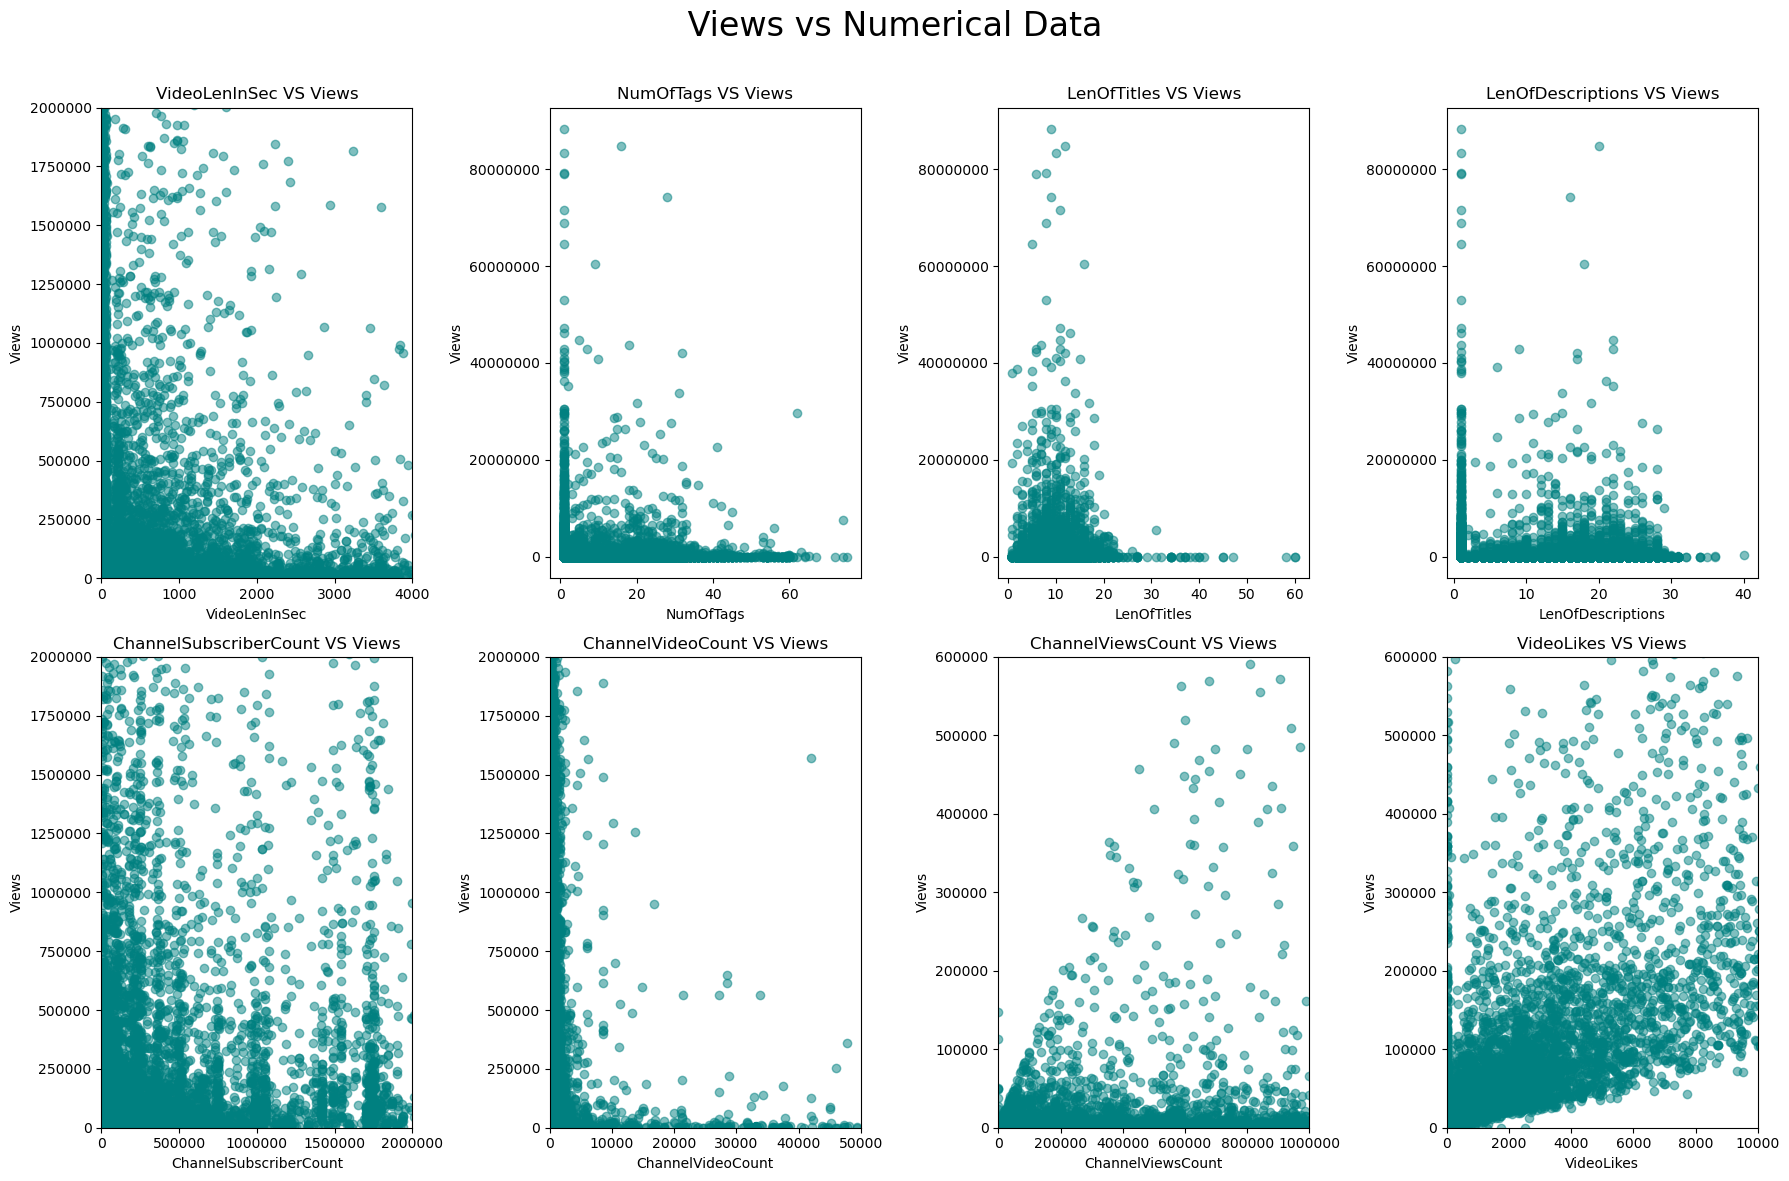

In [359]:
# NumCol = ['views', 'video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len', 
#           'channel_subscriber_count', 'channel_video_count', 'channel_views'] 

fig, ax = plt.subplots(2, 4, figsize=(18, 12))
fig.suptitle(' Views vs Numerical Data ' + '\n', fontsize=24)

ax1 = plt.subplot(2, 4, 1)
plt.scatter(fitness_data.video_len_in_sec, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('VideoLenInSec')
plt.ylabel('Views')
plt.title('VideoLenInSec VS Views')
plt.ticklabel_format(style='plain')
plt.xlim([0, 4000])
plt.ylim([0, 2000000])

ax2 = plt.subplot(2, 4, 2)
plt.scatter(fitness_data.tag_cnt, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('NumOfTags')
plt.ylabel('Views')
plt.title('NumOfTags VS Views')
plt.ticklabel_format(style='plain')



ax3 = plt.subplot(2, 4, 3)
plt.scatter(fitness_data.title_len, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('LenOfTitles')
plt.ylabel('Views')
plt.title('LenOfTitles VS Views')
plt.ticklabel_format(style='plain')

ax4 = plt.subplot(2, 4, 4)
plt.scatter(fitness_data.desc_len, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('LenOfDescriptions')
plt.ylabel('Views')
plt.title('LenOfDescriptions VS Views')
plt.ticklabel_format(style='plain')


ax5 = plt.subplot(2, 4, 5)
plt.scatter(fitness_data.channel_subscriber_count, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('ChannelSubscriberCount')
plt.ylabel('Views')
plt.title('ChannelSubscriberCount VS Views')
plt.ticklabel_format(style='plain')
plt.xlim([0, 2000000])
plt.ylim([0, 2000000])

ax6 = plt.subplot(2, 4, 6)
plt.scatter(fitness_data.channel_video_count, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('ChannelVideoCount')
plt.ylabel('Views')
plt.title('ChannelVideoCount VS Views')
plt.ticklabel_format(style='plain')
plt.xlim([0, 50000])
plt.ylim([0, 2000000])

ax7 = plt.subplot(2, 4, 7)
plt.scatter(fitness_data.channel_views, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('ChannelViewsCount')
plt.ylabel('Views')
plt.title('ChannelViewsCount VS Views')
plt.ticklabel_format(style='plain')
plt.xlim([0, 1000000])
plt.ylim([0, 600000])

ax8 = plt.subplot(2, 4, 8)
plt.scatter(fitness_data.likes, fitness_data.views, color = 'teal', alpha=0.5)
plt.xlabel('VideoLikes')
plt.ylabel('Views')
plt.title('VideoLikes VS Views')
plt.ticklabel_format(style='plain')
plt.xlim([0, 10000])
plt.ylim([0, 600000])


plt.tight_layout()
plt.show()
# plt.savefig('Fig/ViewsPlot7.png')

Text(0.5, 1.0, 'Video Tags Popular Words\n')

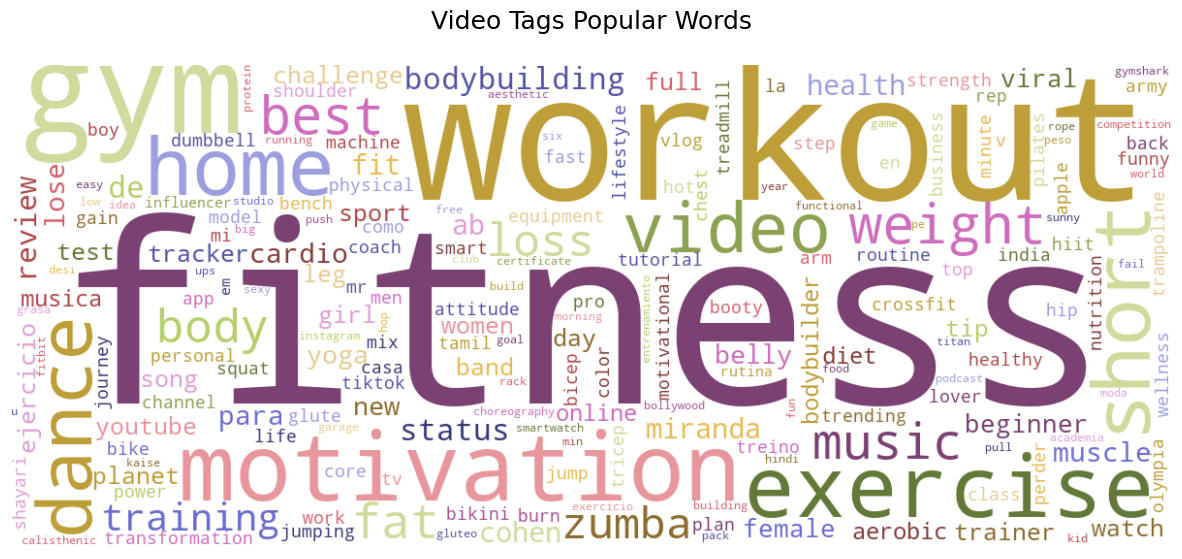

In [361]:
video_tags = list(fitness_data[fitness_data['cleaned_tags'] != '[none]']['cleaned_tags'].apply(lambda x: x.split(',')))
video_tags = [x.lower() for y in video_tags for x in y]


wd = WordCloud(width=1200, height=500, 
               collocations=False, background_color="white",
               colormap="tab20b").generate(" ".join(video_tags))
plt.figure(figsize=(15, 10))
plt.imshow(wd, interpolation='bilinear')
_ = plt.axis("off")
plt.title('Video Tags Popular Words' + '\n', fontsize=18)

# plt.savefig('Fig/ViewsCloud.png')

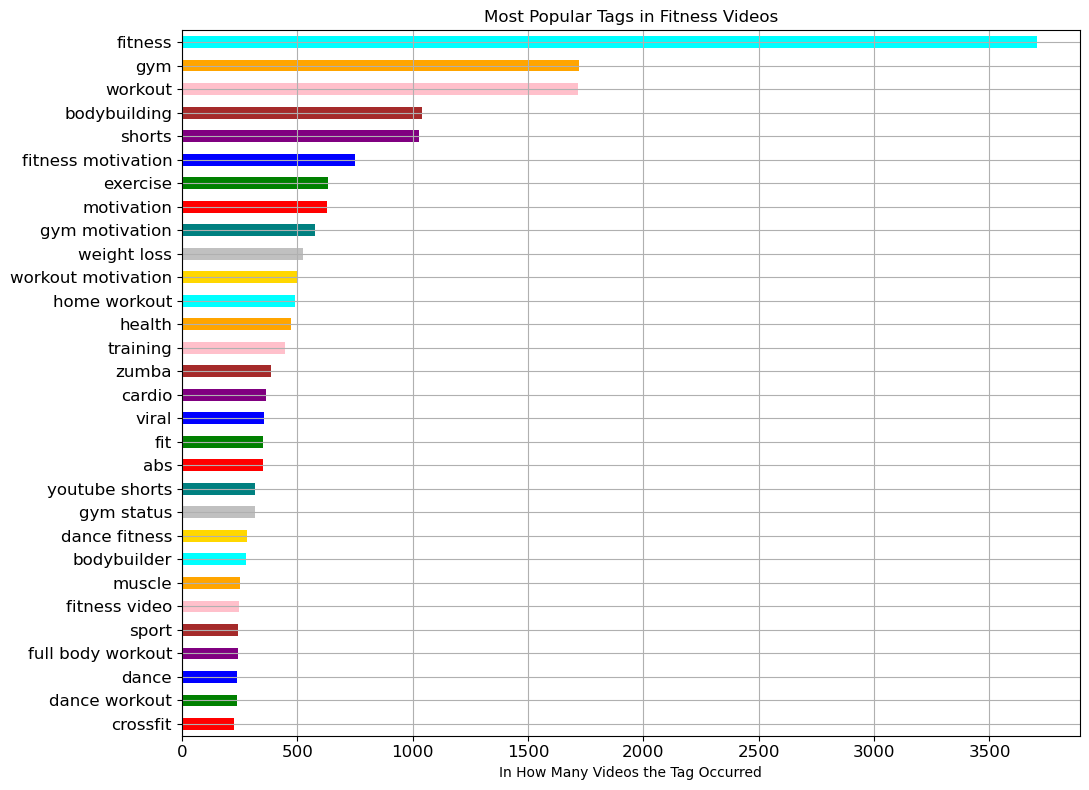

In [358]:
tagcountslice = pd.Series(video_tags).value_counts()[:30].sort_values()
tagcountslice.plot(kind='barh', title='Most Popular Tags in Fitness Videos',
                   grid=True, fontsize=12, figsize=(11,8),
                   color=['red','green','blue','purple','brown','pink','orange','cyan','gold','silver','teal'])
plt.xlabel('In How Many Videos the Tag Occurred')

plt.tight_layout()
# plt.show()
plt.savefig('Fig/ViewsPopular.png')

### 2.4 Feature selection

In [139]:
#see the number of missing values from the data frame
data_missing_value = fitness_data.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,country_code,0
1,video_id,0
2,published_at,0
3,published_date,0
4,data_fetch_date,0
5,title,0
6,description,0
7,thumbnail_link,0
8,video_len_in_sec,0
9,views,0


Convert to english text

In [7]:
# convert text to english
from unidecode import unidecode

for col in CatCol:
    fitness_data[col] = fitness_data[col].apply(unidecode)
    
fitness_data[col]

0        check,new,kove,commuter,2,speaker,here:,http:/...
1        let's,kid,fit,go!,first,8-minute,hiit,session,...
2        workout,fitness,games,kids,home,suitable,whole...
3        eve,victoria,gracie,created,fitjitsu,awesome,f...
4        home,workout,energized,feeling,great!,let,plan...
                               ...                        
24571    track,pints,putts,,joined,coach,kevin,duffy,,t...
24572    fitness,brand,went,zero,$50+,million,first,yea...
24573    6,amazing,exercise,glute,workout,|,changement,...
24574                                                     
24575                         got,u,clicked,on.,surprised?
Name: cleaned_description, Length: 24576, dtype: object

In [226]:
# import pandas as pd
# import unicodedata

# # check if data in english, number, or special characters
# def is_english_special(string):   
#     for char in string:
#         if unicodedata.category(char) not in ['Lu', 'Ll', 'Lt', 'Lm', 'Lo', 'Nd', 'Nl', 'No', 'Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po']:
#             return False
#     return True

# mask = fitness_data['cleaned_tags'].apply(is_english_special) | fitness_data['cleaned_title'].apply(is_english_special) | fitness_data['cleaned_description'].apply(is_english_special)

# en_fitness_data = fitness_data[mask]
# en_fitness_data[:3]


,country_code,video_id,published_at,published_date,data_fetch_date,title,description,thumbnail_link,video_len_in_sec,views,...,channel_topic_categories,channel_topic_categories_ref,channel_keywords,channel_published_date,tag_cnt,title_len,desc_len,cleaned_tags,cleaned_title,cleaned_description
0,US,dvT1k-kdcKY,2020-04-01T13:11:24Z,2020-04-01,2023-02-16,7 Fitness Hacks To Quickly INCREASE MUSCLE,Check out the New Kove Commuter 2 Speaker here...,https://i.ytimg.com/vi/dvT1k-kdcKY/default.jpg,478.0,200703.0,...,[Lifestyle],[https://en.wikipedia.org/wiki/Lifestyle_(soci...,"""fashion tips"" ""men's fashion tips"" ""men's fas...",2012-09-14,16.0,7.0,19.0,"tmf,teachign mens fashion,jose zuniga,mens wea...","7,fitness,hacks,quickly,increase,muscle","check,new,kove,commuter,2,speaker,here:,http:/..."
1,US,fomkRYcl_mo,2020-04-01T18:24:29Z,2020-04-01,2023-02-16,Super fun KID&#39;S Workout! 8-Minute HIIT fit...,Let's Kid Fit GO! Our first 8-minute HIIT sess...,https://i.ytimg.com/vi/fomkRYcl_mo/default.jpg,511.0,1238826.0,...,"[Society, Lifestyle]","[https://en.wikipedia.org/wiki/Society, https:...",,2018-09-27,17.0,14.0,27.0,"the body coach,joe wicks,kids workout,lean in ...","super,fun,kid&#39;s,workout!,8-minute,hiit,fit...","let's,kid,fit,go!,first,8-minute,hiit,session,..."
2,US,q1tiNPiZcco,2020-04-01T07:35:49Z,2020-04-01,2023-02-16,10x FITNESS GAMES - Kids Workout Exercise Game...,Workout fitness games for kids at home suitabl...,https://i.ytimg.com/vi/q1tiNPiZcco/default.jpg,851.0,101877.0,...,"[Fitness, Lifestyle]",[https://en.wikipedia.org/wiki/Physical_fitnes...,"workout workouts ""home workout"" ""coach ali"" ""c...",2014-12-09,22.0,14.0,21.0,"kids workout at home,kids workout,kids fitness...","10x,fitness,games,-,kids,workout,exercise,game...","workout,fitness,games,kids,home,suitable,whole..."


In [8]:
## Drop columns
# data_clean = data.drop(['publish_date','description','title','channel_title','tags','publish_time'], axis=1)

features = ['channel_id', 'views',
            'cleaned_tags', 'cleaned_title', 'cleaned_description', 
            'video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len',
            'channel_subscriber_count', 'channel_video_count', 'channel_views']

fitness_features = fitness_data[features]
fitness_features.head()


,channel_id,views,cleaned_tags,cleaned_title,cleaned_description,video_len_in_sec,tag_cnt,title_len,desc_len,channel_subscriber_count,channel_video_count,channel_views
0,UChNN7VBxPTiNrqjUaQd9bxA,200703.0,"tmf,teachign mens fashion,jose zuniga,mens wea...","7,fitness,hacks,quickly,increase,muscle","check,new,kove,commuter,2,speaker,here:,http:/...",478.0,16.0,7.0,19.0,6050000.0,2243.0,1.003091e+09
1,UCNmjpJa5O7AAQ7fxV0_w1dQ,1238826.0,"the body coach,joe wicks,kids workout,lean in ...","super,fun,kid&#39;s,workout!,8-minute,hiit,fit...","let's,kid,fit,go!,first,8-minute,hiit,session,...",511.0,17.0,14.0,27.0,21500.0,63.0,4.180130e+06
2,UCI2HP_vXCbdWAeY_VCMgDSg,101877.0,"kids workout at home,kids workout,kids fitness...","10x,fitness,games,-,kids,workout,exercise,game...","workout,fitness,games,kids,home,suitable,whole...",851.0,22.0,14.0,21.0,106000.0,1508.0,1.145768e+07
3,UCNMZWa1QP42jHrmmzayFEeg,23785.0,"gracie,breakdown,ufc,mma,rener,ryron,academy,b...","fitjitsu,=,fitness,+,jiu-jitsu,(without,partner)","eve,victoria,gracie,created,fitjitsu,awesome,f...",49.0,14.0,8.0,22.0,836000.0,606.0,1.756950e+08
4,UCZ0PnRz4jxOLZZ9XvGCiqfA,54432.0,"united we move,planet fitness,gym,exercise,wor...","full-body,home,work-in,planet,fitness,trainer,...","home,workout,energized,feeling,great!,let,plan...",1164.0,14.0,9.0,21.0,90000.0,378.0,8.891012e+06


In [9]:
# save feature data to a pickle file
import dill
with open('Data/fitness-feature-data', 'wb') as f:
    dill.dump(fitness_features, f)


## 3. Build Machine Learning models with hyperparameter tune


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [261]:
fitness_data.dtypes

country_code                     object
video_id                         object
published_at                     object
published_date                   object
data_fetch_date                  object
title                            object
description                      object
thumbnail_link                   object
video_len_in_sec                float64
views                           float64
likes                           float64
comments                        float64
tags                             object
channel_id                       object
channel_title                    object
channel_description              object
channel_published_time           object
channel_views                   float64
channel_subscriber_count        float64
channel_video_count             float64
channel_topic_ids                object
channel_topic_categories         object
channel_topic_categories_ref     object
channel_keywords                 object
channel_published_date           object


#### 3.1 Numeric Models - include 'likes' and 'comments' in features

##### Split the data into training and testing with optional portion

In [11]:
# Create this data splits to test out results when model use likes and comments as features
A = fitness_data.drop('views', axis=1)
b = fitness_data.views

Atrain, Atest, btrain, btest = train_test_split(A, b, test_size=0.2, random_state=42)


#####  3.1.1 Random Forest Model (include 'likes' and 'comments' )

In [12]:
def eval_regression_ex(model, pred, Atrain, btrain, Atest, btest):
    print("MAE: %.2f" % mean_absolute_error(btest, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(btest, pred, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(btest, pred)) # Explained variance score: 1 is perfect prediction
    
# target_column = ['video_len_in_sec', 'likes', 'comments', 'tag_cnt', 'channel_views', 'channel_video_count']  
    
target_column = ['video_len_in_sec',  'likes', 'comments', 'tag_cnt', 'title_len', 'desc_len', 
                 'channel_video_count', 'channel_views']  # 'channel_subscriber_count'
                 
              
rfRegressor = RandomForestRegressor(random_state=204)
num_model_ex_1 = Pipeline([
    ('features', ColumnTransformer([('num', 'passthrough', target_column)], remainder='drop')),
    ('rf', rfRegressor)
])

num_mdl_ex_1 = num_model_ex_1.fit(Atrain, btrain)
pred_num_rf_ex = num_mdl_ex_1.predict(Atest)
pred_num_rf_ex = [round(x, 1) for x in pred_num_rf_ex]

eval_regression_ex(num_model_ex_1, pred_num_rf_ex, Atrain, btrain, Atest, btest)

output_num_ex_1 = pd.DataFrame( data={"views":btest, "views_preds":pred_num_rf_ex})
output_num_ex_1

# # with like and comments
# MAE: 170197.51
# RMSE: 1208952.54
# R2 score: 0.80

MAE: 190786.73
RMSE: 1388439.38
R2 score: 0.71


,views,views_preds
2350,442530.0,3002752.2
23251,32499.0,43343.5
11000,122132.0,115842.3
13627,23.0,24.7
21896,695.0,1428.3
...,...,...
2026,18677.0,30408.6
18673,5274.0,4933.0
10941,599447.0,876514.9
14088,4559178.0,3015581.0


##### 3.1.2 Decision Tree Model (include 'likes' and 'comments' )

In [233]:
target_column = ['video_len_in_sec',  'likes', 'comments', 'tag_cnt', 'title_len', 'desc_len', 
                 'channel_subscriber_count', 'channel_video_count', 'channel_views'] 

# NumericCol = ['video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len', 
#           'channel_subscriber_count', 'channel_video_count', 'channel_views'] 

dtRegressor = DecisionTreeRegressor()
num_model_ex_2 = Pipeline([
    ('features', ColumnTransformer([('num', 'passthrough', target_column)], remainder='drop')),
    ('dt', dtRegressor)
])

num_dt_ex_2 = num_model_ex_2.fit(Atrain, btrain)
pred_num_dt_ex_2 = num_dt_ex_2.predict(Atest)
pred_num_dt_ex_2 = [round(x, 1) for x in pred_num_dt_ex_2]
eval_regression_ex(num_model_ex_2, pred_num_dt_ex_2, Atrain, btrain, Atest, btest)


output_num_ex_2 = pd.DataFrame( data={"video_id":Atest["video_id"], "views":btest, "views_preds":pred_num_dt_ex_2})
output_num_ex_2

# # with like and comments
# MAE: 209066.20
# RMSE: 1540896.50
# R2 score: 0.65

MAE: 220573.37
RMSE: 1717536.65
R2 score: 0.60


,video_id,views,views_preds
2303,boG-92jKPps,427.0,1328.0
21774,i_RaV49yk3c,14474.0,10821.0
6357,epN8tOpP-So,1151.0,1224.0
17694,UOKj8vpylfE,1370281.0,747421.0
4424,LrepSQPDG14,23342.0,21630.0
...,...,...,...
23525,ZPk2amkOAnA,485105.0,813219.0
97,z3VxWU8fzaM,1981.0,528.0
11873,YOm-4xCH_AA,8200.0,5056.0
9474,zto8rBfTYTw,2023.0,561.0


#### 3.2 Numeric Models - exclude likes and comments in the features 

In [209]:
fitness_features.dtypes

channel_id                   object
views                       float64
cleaned_tags                 object
cleaned_title                object
cleaned_description          object
video_len_in_sec            float64
tag_cnt                     float64
title_len                   float64
desc_len                    float64
channel_subscriber_count    float64
channel_video_count         float64
channel_views               float64
dtype: object

###### Split data to training and testing

In [262]:
# Training data split
from sklearn.model_selection import train_test_split


X = fitness_features.drop('views', axis=1)
y = fitness_features.views

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


###### Healper funtion to measure and record model scores

In [536]:
# Define function to get model R2 scores

def eval_model(name, model, pred, X_train, y_train, X_test, y_test):
    print("MAE: %.2f" % mean_absolute_error(y_test, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(y_test, pred, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(y_test, pred)) # Explained variance score: 1 is perfect prediction


def evaluate_model(name, model, pred, X_train, y_train, X_test, y_test):
    Model = name    
    R2 = round(r2_score(y_test, pred), 2)
    RMSE = round(mean_squared_error(y_test, pred, squared=False), 2)
    MAE = round(mean_absolute_error(y_test, pred), 2)
#     data = [[name, R2, RMSE, MAE]]  
#     df = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE'])
    new_df = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE'])
    row = {'Model': Model, 'R2': R2, 'RMSE': RMSE, 'MAE': MAE} 
    new_df = pd.DataFrame([row])
    return new_df


#### 3.2.1 Random Forest Model

In [540]:
# numeric model

NumericCol = ['video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len', 
          'channel_subscriber_count', 'channel_video_count', 'channel_views'] 

# target_column = ['video_len_in_sec', 'likes', 'comments', 'tag_cnt', 'channel_views', 'channel_video_count']

rfRegressor = RandomForestRegressor(random_state=104)

num_model = Pipeline([    
    ('features', ColumnTransformer([('num', 'passthrough', NumericCol)], remainder='drop')),
    ('normalize', MinMaxScaler()),
#     ('scale', StandardScaler()),
    ('rf', rfRegressor)
])

best_num_mdl = num_model.fit(X_train, y_train)
pred_num_rf = best_num_mdl.predict(X_test)
pred_num_rf = [round(x, 1) for x in pred_num_rf]

name = 'num_model_rf_1'
dfM = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE'])
new_df = evaluate_model(name, num_model, pred_num_rf, X_train, y_train, X_test, y_test)

dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(df)

output_num_1 = pd.DataFrame( data={"views":y_test, "views_preds":pred_num_rf})
output_num_1

# # without like and comments
# MAE: 515181.41
# RMSE: 2500900.02
# R2 score: 0.06

# # save model into pickle file
# with open('Model/num_mdl', 'wb') as f:
#     dill.dump(num_model, f)

            Model    R2        RMSE        MAE
0  num_model_rf_1  0.06  2500900.02  515181.41


,views,views_preds
2350,442530.0,2407110.8
23251,32499.0,56832.6
11000,122132.0,1080737.8
13627,23.0,1721.9
21896,695.0,1141.6
...,...,...
2026,18677.0,726692.0
18673,5274.0,1155.4
10941,599447.0,516208.2
14088,4559178.0,1092360.1


###### Save Numeric Model to dill

In [290]:
dill.dump(num_model, open('Model/num_mdl', 'wb'))

loaded_num_model = dill.load(open('Model/num_mdl', 'rb'))

result_num = loaded_num_model.score(X_test,y_test)
print('Model Score : ', str(round(result_num,2)*100), '%')

print('train accuracy : ', str(round(loaded_num_model.score(X_train, y_train), 2)*100), '%')
print('test accuracy : ', str(round(loaded_num_model.score(X_test, y_test), 2)*100), '%')

# Model Score :  5.0 %
# train accuracy :  82.0 %
# test accuracy :  5.0 %

# Model Score :  19.0 %
# train accuracy :  81.0 %
# test accuracy :  19.0 %

Model Score :  6.0 %
train accuracy :  82.0 %
test accuracy :  6.0 %


#### 3.2.2 Decision Tree Model

In [541]:
NumericCol = ['video_len_in_sec', 'tag_cnt', 'title_len', 'desc_len', 
              'channel_subscriber_count', 'channel_video_count', 'channel_views'] 

dtRegressor = DecisionTreeRegressor()
num_model_2 = Pipeline([
    ('features', ColumnTransformer([('num', 'passthrough', NumericCol)], remainder='drop')),
    ('dt', dtRegressor)
])

num_dt_2 = num_model_2.fit(X_train, y_train)
pred_num_dt = num_dt_2.predict(X_test)
pred_num_dt = [round(x, 1) for x in pred_num_dt]

name = 'num_model_dt_2'
new_df = evaluate_model(name, num_model_2, pred_num_dt, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_num_2 = pd.DataFrame( data={"views":y_test, "views_preds":pred_num_dt})
output_num_2

# # without like and comments
# MAE: 572374.62
# RMSE: 2936377.19
# R2 score: -0.03

# save Model
# dill.dump(num_model, open('Model/num_mdl', 'wb'))


            Model    R2        RMSE        MAE
0  num_model_rf_1  0.06  2500900.02  515181.41
1  num_model_dt_2 -0.80  3459800.57  600449.08


,views,views_preds
2350,442530.0,1924264.0
23251,32499.0,26951.0
11000,122132.0,2643104.0
13627,23.0,12.0
21896,695.0,695.0
...,...,...
2026,18677.0,1238826.0
18673,5274.0,1053.7
10941,599447.0,599447.0
14088,4559178.0,1856379.0


### Concluesion for Numeric Models: 
- Random Forest Model perform better than Decision Tree
- With 'likes' and 'comments' data, model performs better. 
- This project use pre-posting video data to make prediction

### 3.3 Text Models

###### Use text columns: tags, title, and description to predict views

In [271]:
# Convert raw data to pandas dataframe
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        return pd.DataFrame(X)


# Change 2d array to 1d array
class FlattenArray(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):      
        return X.ravel()

#### 3.3.1 Use Video Description to predict views

##### 3.3.1.1 RidgeCV Model

In [542]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

### Description 1 ####
# cv_description = CountVectorizer(
# #     max_features = 4000
#     min_df = 0.001,
#     ngram_range = (1,3),
#     max_features=300,
#     max_df=0.8 
# )

tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
)

target_column = ['cleaned_description']

description_model_1 = Pipeline([  
    ('to_data_frame', ToDataFrame()),  
    ('features', ColumnTransformer([('feature', 'passthrough', target_column)], remainder='drop')),    
    ('flat', FlattenArray()),    
    ('tfidf', tfidf),    
#     ('count_vectorizer', cv_description),
#     ('scaling', MaxAbsScaler()),
    ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0)))

])

description_model_1 = description_model_1.fit(X_train, y_train)
pred_description_model_1 = description_model_1.predict(X_test)

print(tfidf.get_feature_names_out())
name = 'description_model_1'
new_df = evaluate_model(name, description_model_1, pred_description_model_1, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_description_1 = pd.DataFrame(data={"views":y_test, "views_preds":pred_description_model_1})
output_description_1

# R2 score:  0.006331006444044163
# R2 score:  0.012189914228441179

# # save model into pickle file
# with open('Model/description_model_1', 'wb') as f:
#     dill.dump(description_model_1, f)


['00' '00 00' '01' ... 'zumbafitness tiktokviral' 'zur' 'zyzz']
                 Model    R2        RMSE        MAE
0       num_model_rf_1  0.06  2500900.02  515181.41
1       num_model_dt_2 -0.80  3459800.57  600449.08
2  description_model_1  0.01  2566541.23  644910.26


,views,views_preds
2350,442530.0,254856.185548
23251,32499.0,332332.054610
11000,122132.0,417155.262440
13627,23.0,417155.262440
21896,695.0,417155.262440
...,...,...
2026,18677.0,312207.909156
18673,5274.0,417155.262440
10941,599447.0,924400.785836
14088,4559178.0,345980.198009


##### 3.3.1.2 MLP Model

In [344]:
### Description 2 ####

target_column = ['cleaned_description']

tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
)

mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=5000)

description_model_2 = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),   
    ('tfidf', tfidf),
    ('mlp', mlp)
])

description_model_2 = description_model_2.fit(X_train, y_train)
pred_description_model_2 = description_model_2.predict(X_test)

print(tfidf.get_feature_names_out())
name = 'description_model_2'
new_df = evaluate_model(name, description_model_2, pred_description_model_2, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)


output_description_2 = pd.DataFrame(data={"views":y_test, "views_preds":pred_description_model_2})
output_description_2

# R2 score:  0.02013832384052075  - 500 max_iter
# R2 score:  0.01952807160292921 - 5000

# # Save model
# with open('Model/description_model_2', 'wb') as f:
#     dill.dump(description_model_2, f)    


R2 score:  0.01952807160292921
['00' '00 00' '01' ... 'zumbafitness tiktokviral' 'zur' 'zyzz']


,views,views_preds
2350,442530.0,4054.0
23251,32499.0,479305.0
11000,122132.0,3.0
13627,23.0,3.0
21896,695.0,3.0
...,...,...
2026,18677.0,1647917.0
18673,5274.0,3.0
10941,599447.0,91307.0
14088,4559178.0,10239.0


#### 3.3.2 Use Video Title to predict views

##### 3.3.2.1 RidgeCV Model

In [543]:
### Title 1 ####
# cv_title = CountVectorizer(
#     max_features=300,
#     max_df=0.8
# )
tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
)

target_column = ['cleaned_title']

title_model_1 = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),
#     ('count_vectorizer', cv_title),
    ('tfidf', tfidf),
    ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0)))
])


title_rdgcv_1 = title_model_1.fit(X_train, y_train)
pred_title_1 = title_rdgcv_1.predict(X_test)

print(tfidf.get_feature_names_out())
name = 'title_model_1'
new_df = evaluate_model(name, title_model_1, pred_title_1, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_title_1 = pd.DataFrame(data={"views":y_test, "views_preds":pred_title_1})
output_title_1

# R2 score:  0.025311930602677446
# R2 score:  0.034359034737661
# R2 score:  0.07289333074962112


# # save model into dill file
# with open('Model/title_model_1', 'wb') as f:
#     dill.dump(title_model_1, f)
    

['000' '01' '02' ... 'zyzz' 'zyzz fitness' 'zyzz shorts']
                 Model    R2        RMSE        MAE
0       num_model_rf_1  0.06  2500900.02  515181.41
1       num_model_dt_2 -0.80  3459800.57  600449.08
2  description_model_1  0.01  2566541.23  644910.26
3        title_model_1  0.07  2486430.76  643433.11


,views,views_preds
2350,442530.0,303744.062688
23251,32499.0,-14902.358216
11000,122132.0,145341.929835
13627,23.0,231666.526902
21896,695.0,-59126.481172
...,...,...
2026,18677.0,210935.598929
18673,5274.0,629.719962
10941,599447.0,1302.618952
14088,4559178.0,433159.034271


##### 3.3.2.2 MLP Model

In [345]:
### Title 2 ####
# cv_title_2 = CountVectorizer(
#     max_features=4000,
#     max_df=0.8,
#     min_df=0.01
# )

tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
)

mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=5000)
target_column = ['cleaned_title']
title_model_2 = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),
    ('tfidf', tfidf),
    ('mlp', mlp)

])

title_model_2 = title_model_2.fit(X_train, y_train)
pred_title_model_2 = title_model_2.predict(X_test)

print(tfidf.get_feature_names_out())
name = 'title_model_2'
new_df = evaluate_model(name, title_model_2, pred_title_model_2, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)
        
output_title_2 = pd.DataFrame(data={"views":y_test, "views_preds":pred_title_model_2})
output_title_2

# R2 score:  0.053295362082994305   # 500 iter
# R2 score:  0.05187144019528071   # 5000 iter

# # Save model
# with open('Model/title_model_2', 'wb') as f:
#     dill.dump(title_model_2, f)


R2 score:  0.05187144019528071
['000' '01' '02' ... 'zyzz' 'zyzz fitness' 'zyzz shorts']


,views,views_preds
2350,442530.0,212776.0
23251,32499.0,22421.0
11000,122132.0,3130.0
13627,23.0,0.0
21896,695.0,695.0
...,...,...
2026,18677.0,1647917.0
18673,5274.0,944.0
10941,599447.0,91307.0
14088,4559178.0,7.0


#### 3.3.3 Use Video Tags to predict views

##### 3.3.3.1 RidgeCV Model

In [544]:
### Tags 1 ####
# cv_tags1 = CountVectorizer(
#     max_features=4000,
#     max_df=0.8,
#     min_df=0.01, 
#     ngram_range=(1,2)
# )

tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
)

mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=500)

# Bag of words model
target_column = ['cleaned_tags']

tag_model_1 = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),
#     ('count_vectorizer', cv_tags1),
    ('tfidf', tfidf),
    ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0)))
#     ('mlp', mlp)
])

tag_mdl_1 = tag_model_1.fit(X_train, y_train)
pred_tag_model_1 = tag_mlp_1.predict(X_test)
pred_tag_model_1 = [round(x, 1) for x in pred_tag_model_1]

print(tfidf.get_feature_names_out())
name = 'tag_model_1'
new_df = evaluate_model(name, tag_mdl_1, pred_tag_model_1, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_tag_1 = pd.DataFrame(data={"views":y_test, "views_preds":pred_tag_model_1} )
output_tag_1

# R2 score:  0.002290725043119668
# R2 score:  0.00801970692457843


# # save model into pickle file
# with open('Model/tag_model_1', 'wb') as f:
#     dill.dump(tag_model_1, f)


['10' '10 days' '10 min' ... 'zwift' 'zyzz' 'zyzz hardstyle']
                 Model    R2        RMSE        MAE
0       num_model_rf_1  0.06  2500900.02  515181.41
1       num_model_dt_2 -0.80  3459800.57  600449.08
2  description_model_1  0.01  2566541.23  644910.26
3        title_model_1  0.07  2486430.76  643433.11
4          tag_model_1  0.01  2571953.07  641805.65


,views,views_preds
2350,442530.0,413724.4
23251,32499.0,34924.8
11000,122132.0,406155.5
13627,23.0,406155.5
21896,695.0,406155.5
...,...,...
2026,18677.0,508990.1
18673,5274.0,406155.5
10941,599447.0,228524.9
14088,4559178.0,946222.3


##### 3.3.3.2 MLP Model

In [346]:
### Tags 2 ####
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
)

mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=5000)

target_column = ['cleaned_tags']
tag_model_2 = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),   
    ('tfidf', tfidf),
    ('mlp', mlp)
])

tag_model_2 = tag_model_2.fit(X_train, y_train)
Pred_tag_model_2 = tag_model_2.predict(X_test)
Pred_tag_model_2 = [round(x, 1) for x in Pred_tag_model_2]

print(tfidf.get_feature_names_out())
name = 'tag_model_2'
new_df = evaluate_model(name, tag_model_2, Pred_tag_model_2, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_tag_2 = pd.DataFrame( data={"views":y_test, "views_preds":Pred_tag_model_2} )
output_tag_2[:20]

# R2 score:  0.014442636289666395  # 500 iter
# R2 score:  0.014239218877135883  # 5000 iter


# # Save model 
# with open('Model/tag_model_2', 'wb') as f:
#     dill.dump(tag_model_2, f)
    

R2 score:  0.014239218877135883
['10' '10 days' '10 min' ... 'zwift' 'zyzz' 'zyzz hardstyle']


,views,views_preds
2350,442530.0,866339.0
23251,32499.0,57158.0
11000,122132.0,0.0
13627,23.0,0.0
21896,695.0,0.0
6332,16.0,0.0
2534,2448.0,0.0
11263,5488.0,0.0
8913,14141.0,131.0
9532,1286.0,1225.0


###### Use different parameters

In [37]:
## Tags 3 ####

from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

# nlp = spacy.load('en_core_web_sm')
# STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS
# def tokenize_lemma(text):
#     return [word.lemma_.lower() for word in nlp(text)]

# stop_words_lemma = set(tokenize_lemma(' '.join(STOP_WORDS)))
tfidf = TfidfVectorizer(max_features=4000,
                        ngram_range=(1,2)
#                         stop_words=stop_words_lemma,
#                         tokenizer=tokenize_lemma,
#                         token_pattern=None
)

# cv_tags1 = CountVectorizer(
#     max_features=300,
#     max_df=0.8
# )

# cv_tags2 = CountVectorizer(
#     analyzer = 'word',
#     tokenizer = None,
#     min_df=0.01,    
#     max_df=0.8, 
#     max_features=5000,    
#     ngram_range=(1,2)
# )

# cv_tags3 = CountVectorizer(
#     ngram_range = (2,2),
#     min_df = 0.0001,
#     max_features = 100000
# )

mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=500)

# Bag of words model
target_column = ['cleaned_tags']

tag_model_3 = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),   
#     ('countvector', CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1,2))),
#     ('countvector', cv_tags2),
#     ('tfidf', TfidfTransformer()),
#     ('ridge', Ridge(alpha = 9)),
#     ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0)))
#     ('ran_forest_regressot', RandomForestRegressor())  
    ('tfidf', tfidf),
    ('mlp', mlp)
])

tag_mlp_3 = tag_model_3.fit(X_train, y_train)
tag_views_3 = tag_mlp_3.predict(X_test)

r2_score_on_test_tags_3 = tag_model_3.score(X_test, y_test)
print("R2 score: ", r2_score_on_test_tags_3)
print(tfidf.get_feature_names_out())


output_tag_3 = pd.DataFrame( data={"views":y_test, "views_preds":tag_views_3} )
output_tag_3

## R2 score:  0.015052888527257934

R2 score:  0.014239218877135883
['10' '10 days' '10 min' ... 'टन' 'बढ' 'बन']


,video_id,views,views_preds
2350,6mapfKBwQgA,442530.0,1905.0
23251,7chYHYr2wMA,32499.0,37754.0
11000,SyBbVcIFo5A,122132.0,0.0
13627,ZngpfpyjoPY,23.0,0.0
21896,9onQwlOC0zw,695.0,0.0
...,...,...,...
2026,qBdABgK6IZo,18677.0,1647917.0
18673,arS7hYo-KEw,5274.0,0.0
10941,0XtotbWDpFo,599447.0,599447.0
14088,Hgvp-2y3oEA,4559178.0,349.0


In [134]:
tag_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'to_data_frame', 'features', 'flat', 'countvector', 'tfidf', 'ridge', 'features__n_jobs', 'features__remainder', 'features__sparse_threshold', 'features__transformer_weights', 'features__transformers', 'features__verbose', 'features__verbose_feature_names_out', 'features__rev', 'countvector__analyzer', 'countvector__binary', 'countvector__decode_error', 'countvector__dtype', 'countvector__encoding', 'countvector__input', 'countvector__lowercase', 'countvector__max_df', 'countvector__max_features', 'countvector__min_df', 'countvector__ngram_range', 'countvector__preprocessor', 'countvector__stop_words', 'countvector__strip_accents', 'countvector__token_pattern', 'countvector__tokenizer', 'countvector__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__positive', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [166]:
## Tags 4 ####

# tfidf = TfidfVectorizer(max_features=4000,
#                         ngram_range=(1,2)
# )

# cv_tags4 = CountVectorizer(
#     analyzer = 'word',
#     tokenizer = None,
#     min_df=0.01,    
#     max_df=0.8, 
#     max_features=4000,    
#     ngram_range=(1,2)
# )

cv_tags4 = CountVectorizer(
    max_features=4000,
    max_df=0.8
)

mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=500)

# Bag of words model
target_column = ['cleaned_tags']

tag_model = Pipeline([
    ('to_data_frame', ToDataFrame()),
    ('features', ColumnTransformer([('rev', 'passthrough', target_column)], remainder='drop')),
    ('flat', FlattenArray()),   
#     ('countvector', CountVectorizer(min_df=0.01, max_df=0.8, ngram_range=(1,2))),
    ('countvector', cv_tags4),
    ('ridge', Ridge(alpha = 8))
#     ('ridgeCV', RidgeCV(alphas=(0.1, 1.0, 10.0)))
#     ('ran_forest_regressot', RandomForestRegressor())  
#     ('tfidf', tfidf),
#     ('mlp', mlp)
])

param_grid = {
    'ridge__alpha': range(8,10,1),
#     'countvector__max_features': range(4000, 5000, 500),
#     'countvector__max_df': [0.8, 0.9, 1.0],
#     'countvector__min_df': [0.1, 0.9, 1.0]
}

best_tags_model = GridSearchCV(
    tag_model, 
    param_grid=param_grid, 
    cv=2, 
    n_jobs=2
)

tag_mlp_4 = best_tags_model.fit(X_train, y_train)
tag_views_4 = tag_mlp_4.predict(X_test)

r2_score_on_test_tags_4 = best_tags_model.score(X_test, y_test)
print("R2 score: ", r2_score_on_test_tags_4)
print("The best hyperparameter value is: ", best_tags_model.best_params_)

output_tag_4 = pd.DataFrame( data={"views":y_test, "views_preds":tag_views_4} )
output_tag_4

# R2 score:  0.008155338906005505
# The best hyperparameter value is:  {'ridge__alpha': 9}

R2 score:  0.008155338906005505
The best hyperparameter value is:  {'ridge__alpha': 9}


In [158]:
# R2 score:  0.008083826987494436
# The best hyperparameter value is:  {'countvector__max_df': 0.8, 'countvector__max_features': 4000, 'ridge__alpha': 8}

### 3.4 Combine three text models: Tags, Titles, and Descriptions 

In [340]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        # What needs to be done here?
        self.model = model
    
    def fit(self, X, y):
        # Fit the stored predictor.
        # Question: what should be returned?
        self.model.fit(X,y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.        
        return np.array(self.model.predict(X)).reshape(-1,1)
        

#### 3.4.1 Category data model

In [546]:
from sklearn.pipeline import FeatureUnion

cat_union = FeatureUnion([
#     # FeatureUnion uses the same syntax as Pipeline
#     ('tag_mdl', ModelTransformer(tag_model_3)),
#     ('title_mdl', ModelTransformer(title_model_2)),
#     ('description', ModelTransformer(description_model_2))   
      
    ('tag_mdl', ModelTransformer(tag_model_1)),
    ('title_mdl', ModelTransformer(title_model_1)),
    ('description', ModelTransformer(description_model_1))  
])
# cat_union.fit(X_train, y_train)

cat_model_1 = Pipeline([
    ('union', cat_union),
    ('linear', LinearRegression())
])

cat_model_1.fit(X_train, y_train)
Pred_cat_model_1 = cat_model_1.predict(X_test)

name = 'cat_model_1'
new_df = evaluate_model(name, cat_model_1, Pred_cat_model_1, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_full = pd.DataFrame( data={"views":y_test, "views_preds":Pred_cat_model_1} )
output_full


# # save model
# dill.dump(cat_model, open('Model/cat_mdl_1', 'wb'))

# R2 score:  0.05263793323809851


                 Model    R2        RMSE        MAE
0       num_model_rf_1  0.06  2500900.02  515181.41
1       num_model_dt_2 -0.80  3459800.57  600449.08
2  description_model_1  0.01  2566541.23  644910.26
3        title_model_1  0.07  2486430.76  643433.11
4          tag_model_1  0.01  2571953.07  641805.65
5          cat_model_1  0.05  2513445.73  905529.85
6          cat_model_1  0.05  2513445.73  905529.85


,views,views_preds
2350,442530.0,1.516915e+05
23251,32499.0,-7.650981e+05
11000,122132.0,5.259279e+04
13627,23.0,2.017921e+05
21896,695.0,-3.008006e+05
...,...,...
2026,18677.0,1.703352e+05
18673,5274.0,-1.975208e+05
10941,599447.0,1.651215e+05
14088,4559178.0,1.116416e+06


In [ ]:
from sklearn.pipeline import FeatureUnion

cat_union = FeatureUnion([
    ('tag_mdl', ModelTransformer(tag_model_2)),
    ('title_mdl', ModelTransformer(title_model_2)),
    ('description', ModelTransformer(description_model_2))  
])


cat_model_2 = Pipeline([
    ('union', cat_union),
    ('linear', LinearRegression())
])

cat_model_2.fit(X_train, y_train)
pred_cat_model_2 = cat_model_2.predict(X_test)

name = 'cat_model_2'
new_df = evaluate_model(name, cat_model_2, pred_cat_model_2, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)


output_full = pd.DataFrame( data={"views":y_test, "views_preds":pred_cat_model_2} )
output_full

# R2 score:  0.05263793323809851

# # save model
# dill.dump(cat_model_2, open('Model/cat_mdl_2', 'wb'))


Save Category Models

In [312]:
# dill.dump(cat_model, open('Model/cat_mdl', 'wb'))

loaded_cat_model = dill.load(open('Model/cat_mdl_2', 'rb'))

result_cat = loaded_cat_model.score(X_test,y_test)
print('Model Score : ', str(round(result_cat,2)*100), '%')

print('train accuracy : ', str(round(loaded_cat_model.score(X_train, y_train), 2)*100), '%')
print('test accuracy : ', str(round(loaded_cat_model.score(X_test, y_test), 2)*100), '%')

Model Score :  5.0 %
train accuracy :  20.0 %
test accuracy :  5.0 %


### 3.5 Full model include numeric and categories data

#### 3.5.1 Full Model - RidgeCV

In [549]:
from sklearn.pipeline import FeatureUnion

# R2 score:  -0.08674550231096023
full_union = FeatureUnion([    
    ('num_mdl', ModelTransformer(num_model)),
    ('tag_mdl', ModelTransformer(tag_model_1)),
    ('title_mdl', ModelTransformer(title_model_1)),
    ('description_mdl', ModelTransformer(description_model_1))   
])

full_model_1 = Pipeline([
    ('union', full_union),
    ('linear', LinearRegression())
])

full_model_1 = full_model.fit(X_train, y_train)
pred_full_model_1 = full_model.predict(X_test)

name = 'full_model_1'
new_df = evaluate_model(name, full_model_1, pred_full_model_1, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_full = pd.DataFrame( data={"views":y_test, "views_preds":pred_full_model_1} )
output_full
# R2 score:  0.025523202797898104
# R2 score:  -0.04410067669957707
# R2 score:  0.09106368437938861


# # Save model
# dill.dump(full_model_1, open('Model/full_mdl_1', 'wb'))


                 Model    R2        RMSE        MAE
0       num_model_rf_1  0.06  2500900.02  515181.41
1       num_model_dt_2 -0.80  3459800.57  600449.08
2  description_model_1  0.01  2566541.23  644910.26
3        title_model_1  0.07  2486430.76  643433.11
4          tag_model_1  0.01  2571953.07  641805.65
5          cat_model_1  0.05  2513445.73  905529.85
6          cat_model_1  0.05  2513445.73  905529.85
7         full_model_1 -0.09  2692002.40  656292.78
8         full_model_1 -0.09  2692002.40  656292.78


,views,views_preds
2350,442530.0,3.086881e+06
23251,32499.0,4.960111e+04
11000,122132.0,1.373369e+06
13627,23.0,-9.278649e+04
21896,695.0,-1.680596e+03
...,...,...
2026,18677.0,8.788210e+05
18673,5274.0,-2.054295e+04
10941,599447.0,6.796517e+05
14088,4559178.0,1.304681e+06


In [550]:
# all model scores
dfM

,Model,R2,RMSE,MAE
0,num_model_rf_1,0.06,2500900.02,515181.41
1,num_model_dt_2,-0.80,3459800.57,600449.08
2,description_model_1,0.01,2566541.23,644910.26
3,title_model_1,0.07,2486430.76,643433.11
4,tag_model_1,0.01,2571953.07,641805.65
5,cat_model_1,0.05,2513445.73,905529.85
6,cat_model_1,0.05,2513445.73,905529.85
7,full_model_1,-0.09,2692002.40,656292.78
8,full_model_1,-0.09,2692002.40,656292.78


##### 3.5.2 Full Model - MLP Model

In [347]:
from sklearn.pipeline import FeatureUnion

full_union = FeatureUnion([    
    ('num_mdl', ModelTransformer(num_model)),
    ('tag_mdl', ModelTransformer(tag_model_2)),
    ('title_mdl', ModelTransformer(title_model_2)),
    ('description_mdl', ModelTransformer(description_model_2))   
])

full_model_2 = Pipeline([
    ('union', full_union),
    ('linear', LinearRegression())
])

full_model_2 = full_model_2.fit(X_train, y_train)
pred_full_model_2 = full_model_2.predict(X_test)

name = 'full_model_2'
new_df = evaluate_model(name, full_model_2, pred_full_model_2, X_train, y_train, X_test, y_test)
dfM = pd.concat([dfM, new_df], axis=0, ignore_index=True)
print(dfM)

output_full = pd.DataFrame( data={"views":y_test, "views_preds":pred_full_model_2} )
output_full
# R2 score:  -0.08674550231096023

# # save model
# dill.dump(full_model_2, open('Model/full_mdl_2', 'wb'))


R2 score:  -0.08674550231096023


###### Save full model

In [365]:
# dill.dump(full_model, open('Model/full_mdl', 'wb'))

loaded_full_model = dill.load(open('Model/full_mdl_2', 'rb'))

result_full = loaded_cat_model.score(X_test,y_test)
print('Model Score : ', str(round(result_full,2)*100), '%')

print('train accuracy : ', str(round(loaded_full_model.score(X_train, y_train), 2)*100), '%')
print('test accuracy : ', str(round(loaded_full_model.score(X_test, y_test), 2)*100), '%')

Model Score :  5.0 %
train accuracy :  95.0 %
test accuracy :  -2.0 %


In [128]:
# from sklearn.pipeline import FeatureUnion

# # mlpC = MLPClassifier(hidden_layer_sizes=(100,),max_iter=500)
# # rfReg = RandomForestRegressor(random_state=104)

# full_union = FeatureUnion([
#     # FeatureUnion uses the same syntax as Pipeline
#     ('num_mdl', ModelTransformer(num_model)),
#     ('cat_mdl', ModelTransformer(cat_model)) 
# ])
# # cat_union.fit(X_train, y_train)

# full_model = Pipeline([
#     ('union', full_union),    
#     ('linear', LinearRegression())
# ])

# full_model.fit(X_train, y_train)
# full_model.predict(X_test)

# r2_score_on_test_full_model = full_model.score(X_test, y_test)
# print("R2 score: ", r2_score_on_test_full_model)

# dill.dump(full_model, open('Model/full_mdl', 'wb'))


# # R2 score:  0.025523202797898104
# # R2 score:  -0.04451045593407632
# # R2 score:  0.09139883561568107

R2 score:  0.09139883561568107


In [244]:
# from sklearn.pipeline import FeatureUnion

# union = FeatureUnion([
#     # FeatureUnion uses the same syntax as Pipeline
#     ('num_mdl', ModelTransformer(num_model)),
#     ('tag_mdl', ModelTransformer(tag_model_1)),
#     ('title_mdl', ModelTransformer(title_model_1)),
#     ('description', ModelTransformer(description_model_1))   
# ])
# # cat_union.fit(X_train, y_train)

# text_model = Pipeline([
#     ('union', union),
# #     ('mlp', mlp)
#     ('linear', LinearRegression())
# ])

# text_model.fit(X_train, y_train)
# text_model.predict(X_test)

# r2_score_on_test_cat_model = text_model.score(X_test, y_test)
# print("R2 score: ", r2_score_on_test_cat_model)

# # R2 score:  0.025523202797898104
# # R2 score:  0.09106368437938861

# dill.dump(text_model, open('Model/text_mdl', 'wb'))

# loaded_cat_model = dill.load(open('Model/text_mdl', 'rb'))

# result_cat = loaded_cat_model.score(X_test,y_test)
# print('Model Score : ', str(round(result_cat,2)*100), '%')

# print('train accuracy : ', str(round(loaded_cat_model.score(X_train, y_train), 2)*100), '%')
# print('test accuracy : ', str(round(loaded_cat_model.score(X_test, y_test), 2)*100), '%') 


R2 score:  -0.20467072917109075
